# Import Libraries

In [44]:
import sys
sys.path.append('./pyperch') 

import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer
from torch import nn, optim
from skorch import NeuralNetClassifier
from pyperch.neural.backprop_nn import BackpropModule 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d

/var/folders/v2/n4txv_m576bfzpty03vzg37h0000gn/T/ipykernel_99891/1762722362.py:16: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


# Load Data

In [2]:
cancer_data = load_breast_cancer()
cancer_df = pd.DataFrame(cancer_data['data'], columns = cancer_data['feature_names'])

X_norm = pd.DataFrame(MinMaxScaler().fit_transform(cancer_df), columns=cancer_df.columns)

X_train, X_test, y_train, y_test = train_test_split(X_norm, cancer_data['target'], test_size=0.2, random_state=88)

In [3]:
X_train = np.array(X_train)
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.int64)

In [37]:
X_test = np.array(X_test)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.int64)

# Back Propogation

In [4]:
from skorch.callbacks import EpochScoring 

net = NeuralNetClassifier(
    module=BackpropModule,
    max_epochs=500,
    verbose=0,
    callbacks=[EpochScoring(scoring='f1', name='train_f1', on_train=True),],
    criterion=nn.CrossEntropyLoss,
    optimizer=optim.SGD,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

In [37]:
from sklearn.model_selection import GridSearchCV

# deactivate skorch-internal train-valid split and verbose logging
net.set_params(train_split=False, verbose=0)

default_params = {
    'module__input_dim': [30],
    'module__output_dim': [2],
    'module__hidden_layers': [1],
}

# module specific parameters need to begin with 'module__'
params = {
    'lr': [0.01, 0.06, 0.36, 1.0],
    'module__hidden_units': [8, 32, 64],
    'module__activation': [nn.ReLU(), nn.Sigmoid()],
    **default_params,
}
gs = GridSearchCV(net, params, refit=False, cv=3, scoring='f1', verbose=2)

gs.fit(X_train, y_train)
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END lr=0.01, module__activation=ReLU(), module__hidden_layers=1, module__hidden_units=8, module__input_dim=30, module__output_dim=2; total time=  10.4s
[CV] END lr=0.01, module__activation=ReLU(), module__hidden_layers=1, module__hidden_units=8, module__input_dim=30, module__output_dim=2; total time=   8.8s
[CV] END lr=0.01, module__activation=ReLU(), module__hidden_layers=1, module__hidden_units=8, module__input_dim=30, module__output_dim=2; total time=  10.3s
[CV] END lr=0.01, module__activation=ReLU(), module__hidden_layers=1, module__hidden_units=32, module__input_dim=30, module__output_dim=2; total time=  12.4s
[CV] END lr=0.01, module__activation=ReLU(), module__hidden_layers=1, module__hidden_units=32, module__input_dim=30, module__output_dim=2; total time=  10.4s
[CV] END lr=0.01, module__activation=ReLU(), module__hidden_layers=1, module__hidden_units=32, module__input_dim=30, module__output_dim=2; total time=  

[CV] END lr=0.36, module__activation=Sigmoid(), module__hidden_layers=1, module__hidden_units=64, module__input_dim=30, module__output_dim=2; total time=  15.3s
[CV] END lr=0.36, module__activation=Sigmoid(), module__hidden_layers=1, module__hidden_units=64, module__input_dim=30, module__output_dim=2; total time=  11.8s
[CV] END lr=1.0, module__activation=ReLU(), module__hidden_layers=1, module__hidden_units=8, module__input_dim=30, module__output_dim=2; total time=  11.0s
[CV] END lr=1.0, module__activation=ReLU(), module__hidden_layers=1, module__hidden_units=8, module__input_dim=30, module__output_dim=2; total time=  10.6s
[CV] END lr=1.0, module__activation=ReLU(), module__hidden_layers=1, module__hidden_units=8, module__input_dim=30, module__output_dim=2; total time=  10.8s
[CV] END lr=1.0, module__activation=ReLU(), module__hidden_layers=1, module__hidden_units=32, module__input_dim=30, module__output_dim=2; total time=  12.6s
[CV] END lr=1.0, module__activation=ReLU(), module__h

In [5]:
net = NeuralNetClassifier(
    module=BackpropModule,
    module__input_dim=30,
    module__output_dim=2,
    module__hidden_units=32,
    module__hidden_layers=1,
    module__activation=nn.Sigmoid(),
    max_epochs=8192,
    verbose=0,
    callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True),],
    criterion=nn.CrossEntropyLoss,
    optimizer=optim.SGD,
    lr=1.0,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

In [6]:
net.fit(X_train, y_train)

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=BackpropModule(
    (dropout): Dropout(p=0, inplace=False)
    (activation): Sigmoid()
    (output_activation): Softmax(dim=-1)
    (layers): ModuleList(
      (0): Linear(in_features=30, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=32, bias=True)
      (2): Linear(in_features=32, out_features=2, bias=True)
    )
  ),
)

In [43]:
print(classification_report(y_test, net.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        39
           1       1.00      0.97      0.99        75

    accuracy                           0.98       114
   macro avg       0.98      0.99      0.98       114
weighted avg       0.98      0.98      0.98       114



In [45]:
print(confusion_matrix(y_test, net.predict(X_test)))

[[39  0]
 [ 2 73]]


In [7]:
train_loss_smooth = gaussian_filter1d(net.history[:, 'train_loss'], sigma=2)
valid_loss_smooth = gaussian_filter1d(net.history[:, 'valid_loss'], sigma=2)

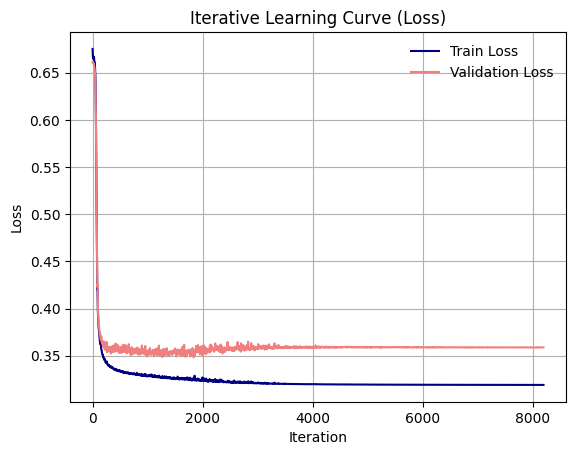

In [14]:
# plot the iterative learning curve (loss)
plt.plot(train_loss_smooth, label='Train Loss', color='navy')
plt.plot(valid_loss_smooth, label='Validation Loss', color='lightcoral')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iterative Learning Curve (Loss)")
plt.grid(visible=True)
plt.legend(frameon=False)

In [13]:
train_acc_smooth = gaussian_filter1d(net.history[:, 'train_acc'], sigma=2)
valid_acc_smooth = gaussian_filter1d(net.history[:, 'valid_acc'], sigma=2)

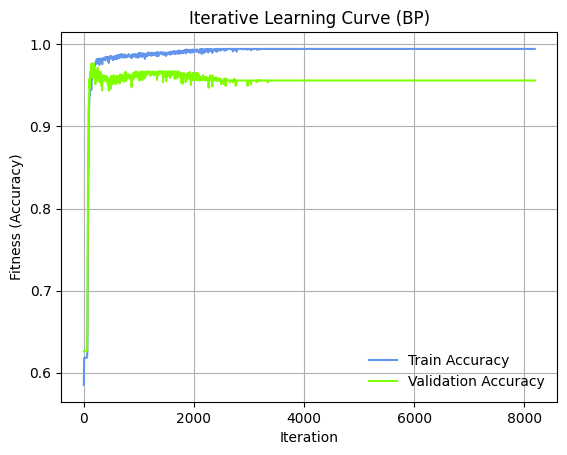

In [15]:
# plot the iterative learning curve (Accuracy)
plt.plot(train_acc_smooth, label='Train Accuracy', color='cornflowerblue')
plt.plot(valid_acc_smooth, label='Validation Accuracy', color='chartreuse')
plt.xlabel("Iteration")
plt.ylabel("Fitness (Accuracy)")
plt.title("Iterative Learning Curve (BP)")
plt.grid(visible=True)
plt.legend(frameon=False)

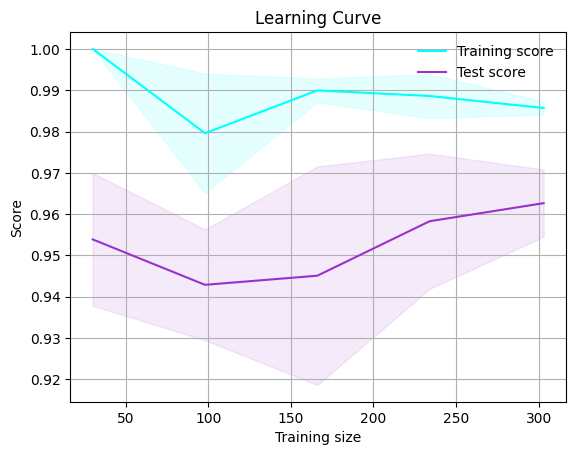

In [70]:
from sklearn.model_selection import learning_curve

# Plot the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    net, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 5), cv=3
)

train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='cyan')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='darkorchid')
plt.plot(train_sizes, train_scores_mean, label="Training score", color='cyan')
plt.plot(train_sizes, test_scores_mean, label="Test score", color='darkorchid')
plt.title("Learning Curve")
plt.xlabel("Training size")
plt.ylabel("Score")
plt.grid(visible=True)
plt.legend(frameon=False)

## RHC

In [16]:
from pyperch.neural.rhc_nn import RHCModule  

In [78]:
rhc_net = NeuralNetClassifier(
    module=RHCModule,
    max_epochs=500,
    verbose=0,
    callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True),],
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

In [83]:
help(RHCModule)

Help on class RHCModule in module pyperch.neural.rhc_nn:

class RHCModule(torch.nn.modules.module.Module)
 |  RHCModule(input_dim, output_dim, hidden_units=10, hidden_layers=1, dropout_percent=0, step_size=0.1, activation=ReLU(), output_activation=Softmax(dim=-1))
 |  
 |  Method resolution order:
 |      RHCModule
 |      torch.nn.modules.module.Module
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, input_dim, output_dim, hidden_units=10, hidden_layers=1, dropout_percent=0, step_size=0.1, activation=ReLU(), output_activation=Softmax(dim=-1))
 |      Initialize the neural network.
 |      
 |      PARAMETERS:
 |      
 |      input_dim {int}:
 |          Number of features/dimension of the input.  Must be greater than 0.
 |      
 |      output_dim {int}:
 |          Number of classes/output dimension of the model. Must be greater than 0.
 |      
 |      hidden_units {int}:
 |          Number of hidden units.
 |      
 |      hidden_layers {int}:
 |     

In [17]:
RHCModule.register_rhc_training_step()

In [81]:
from sklearn.model_selection import GridSearchCV

# deactivate skorch-internal train-valid split and verbose logging
rhc_net.set_params(train_split=False, verbose=0, )

# module specific parameters need to begin with 'module__'
default_params = {
    'module__input_dim': [30],
    'module__output_dim': [2],
    'module__hidden_layers': [1],
    'module__hidden_units': [32],
    'module__activation': [nn.Sigmoid()],
    
}

grid_search_params = {
    'module__step_size': [0.01, 0.1, 1.0],
    **default_params,
}

gs = GridSearchCV(rhc_net, grid_search_params, refit=False, cv=3, scoring='accuracy', verbose=2)

gs.fit(X_train, y_train)
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END module__activation=Sigmoid(), module__hidden_layers=1, module__hidden_units=32, module__input_dim=30, module__output_dim=2, module__step_size=0.01; total time=   6.0s
[CV] END module__activation=Sigmoid(), module__hidden_layers=1, module__hidden_units=32, module__input_dim=30, module__output_dim=2, module__step_size=0.01; total time=   6.0s
[CV] END module__activation=Sigmoid(), module__hidden_layers=1, module__hidden_units=32, module__input_dim=30, module__output_dim=2, module__step_size=0.01; total time=   5.4s
[CV] END module__activation=Sigmoid(), module__hidden_layers=1, module__hidden_units=32, module__input_dim=30, module__output_dim=2, module__step_size=0.1; total time=   5.2s
[CV] END module__activation=Sigmoid(), module__hidden_layers=1, module__hidden_units=32, module__input_dim=30, module__output_dim=2, module__step_size=0.1; total time=   5.5s
[CV] END module__activation=Sigmoid(), module__hidden_layers=1,

In [18]:
rhc_net = NeuralNetClassifier(
    module=RHCModule,
    module__input_dim=30,
    module__output_dim=2,
    module__hidden_units=32,
    module__hidden_layers=1,
    module__activation=nn.Sigmoid(),
    module__step_size=1.0,
    max_epochs=8192,
    verbose=0,
    callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True),],
    criterion=nn.CrossEntropyLoss,
    optimizer=optim.SGD,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

In [19]:
rhc_net.fit(X_train, y_train)

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=RHCModule(
    (dropout): Dropout(p=0, inplace=False)
    (activation): Sigmoid()
    (output_activation): Softmax(dim=-1)
    (layers): ModuleList(
      (0): Linear(in_features=30, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=32, bias=True)
      (2): Linear(in_features=32, out_features=2, bias=True)
    )
  ),
)

In [42]:
print(classification_report(y_test, rhc_net.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96        39
           1       0.99      0.97      0.98        75

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



In [46]:
print(confusion_matrix(y_test, rhc_net.predict(X_test)))

[[38  1]
 [ 2 73]]


In [122]:
train_loss_smooth = gaussian_filter1d(rhc_net.history[:, 'train_loss'], sigma=10)
valid_loss_smooth = gaussian_filter1d(rhc_net.history[:, 'valid_loss'], sigma=10)

/var/folders/v2/n4txv_m576bfzpty03vzg37h0000gn/T/ipykernel_83641/982349133.py:1: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


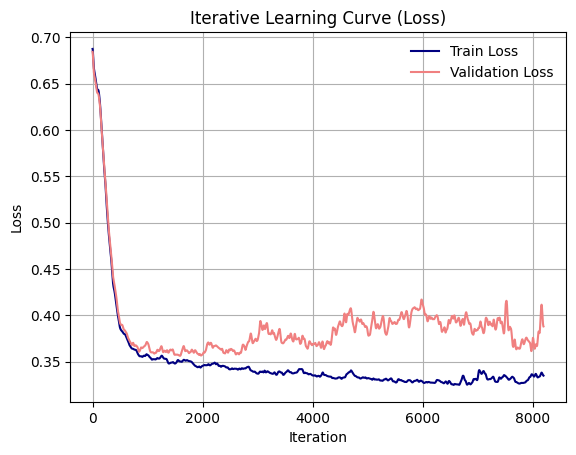

In [123]:
# plot the iterative learning curve (loss)
plt.plot(train_loss_smooth, label='Train Loss', color='navy')
plt.plot(valid_loss_smooth, label='Validation Loss', color='lightcoral')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iterative Learning Curve (Loss)")
plt.grid(visible=True)
plt.legend(frameon=False)

In [20]:
train_acc_smooth = gaussian_filter1d(rhc_net.history[:, 'train_acc'], sigma=2)
valid_acc_smooth = gaussian_filter1d(rhc_net.history[:, 'valid_acc'], sigma=2)

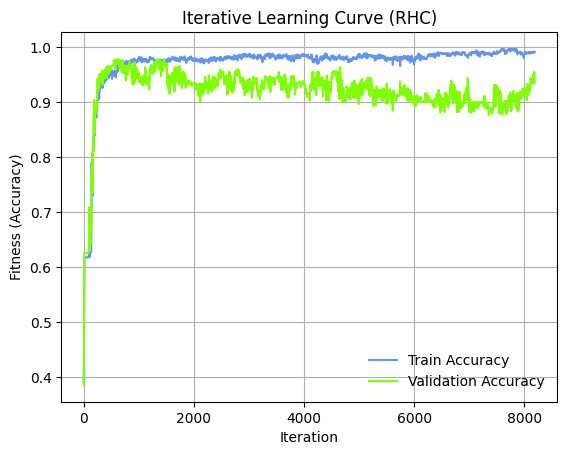

In [21]:
# plot the iterative learning curve (Accuracy)
plt.plot(train_acc_smooth, label='Train Accuracy', color='cornflowerblue')
plt.plot(valid_acc_smooth, label='Validation Accuracy', color='chartreuse')
plt.xlabel("Iteration")
plt.ylabel("Fitness (Accuracy)")
plt.title("Iterative Learning Curve (RHC)")
plt.grid(visible=True)
plt.legend(frameon=False)

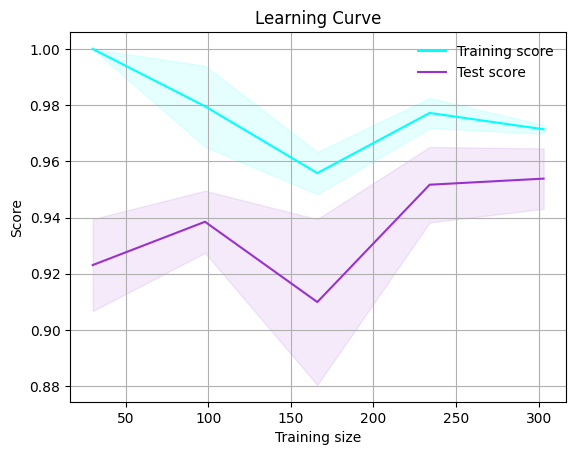

In [140]:
from sklearn.model_selection import learning_curve

# Plot the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    rhc_net, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 5), cv=3
)

train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='cyan')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='darkorchid')
plt.plot(train_sizes, train_scores_mean, label="Training score", color='cyan')
plt.plot(train_sizes, test_scores_mean, label="Test score", color='darkorchid')
plt.title("Learning Curve")
plt.xlabel("Training size")
plt.ylabel("Score")
plt.grid(visible=True)
plt.legend(frameon=False)

## SA

In [22]:
from pyperch.neural.sa_nn import SAModule  


In [23]:
sa_net = NeuralNetClassifier(
    module=SAModule,
    max_epochs=500,
    verbose=0,
    callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True),],
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

In [22]:
help(SAModule)

Help on class SAModule in module pyperch.neural.sa_nn:

class SAModule(torch.nn.modules.module.Module)
 |  SAModule(input_dim, output_dim, t=10000, cooling=0.95, hidden_units=10, hidden_layers=1, dropout_percent=0, step_size=0.1, activation=ReLU(), output_activation=Softmax(dim=-1))
 |  
 |  Method resolution order:
 |      SAModule
 |      torch.nn.modules.module.Module
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, input_dim, output_dim, t=10000, cooling=0.95, hidden_units=10, hidden_layers=1, dropout_percent=0, step_size=0.1, activation=ReLU(), output_activation=Softmax(dim=-1))
 |      Initialize the neural network.
 |      
 |      PARAMETERS:
 |      
 |      input_dim {int}:
 |          Number of features/dimension of the input.  Must be greater than 0.
 |      
 |      output_dim {int}:
 |          Number of classes/output dimension of the model. Must be greater than 0.
 |      
 |      t {int}:
 |          SA temperature.
 |      
 |      coolin

In [24]:
SAModule.register_sa_training_step()

In [89]:
from sklearn.model_selection import GridSearchCV

# deactivate skorch-internal train-valid split and verbose logging
sa_net.set_params(train_split=False, verbose=0, )

# module specific parameters need to begin with 'module__'
default_params = {
    'module__input_dim': [30],
    'module__output_dim': [2],
    'module__hidden_layers': [1],
    'module__hidden_units': [32],
    'module__activation': [nn.Sigmoid()],
    
}

grid_search_params = {
    'module__step_size': [0.01, 0.1, 1.0],
    'module__t': [200, 2000, 20000],
    'module__cooling': [0.2, 0.4, 0.8, 0.9, 0.999999999],
    **default_params,
}

gs = GridSearchCV(sa_net, grid_search_params, refit=False, cv=3, scoring='accuracy', verbose=2)

gs.fit(X_train, y_train)
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 45 candidates, totalling 135 fits
[CV] END module__activation=Sigmoid(), module__cooling=0.2, module__hidden_layers=1, module__hidden_units=32, module__input_dim=30, module__output_dim=2, module__step_size=0.01, module__t=200; total time=   6.1s
[CV] END module__activation=Sigmoid(), module__cooling=0.2, module__hidden_layers=1, module__hidden_units=32, module__input_dim=30, module__output_dim=2, module__step_size=0.01, module__t=200; total time=   5.1s
[CV] END module__activation=Sigmoid(), module__cooling=0.2, module__hidden_layers=1, module__hidden_units=32, module__input_dim=30, module__output_dim=2, module__step_size=0.01, module__t=200; total time=   5.2s
[CV] END module__activation=Sigmoid(), module__cooling=0.2, module__hidden_layers=1, module__hidden_units=32, module__input_dim=30, module__output_dim=2, module__step_size=0.01, module__t=2000; total time=   5.3s
[CV] END module__activation=Sigmoid(), module__cooling=0.2, module__hidden_layers=1, modu

[CV] END module__activation=Sigmoid(), module__cooling=0.4, module__hidden_layers=1, module__hidden_units=32, module__input_dim=30, module__output_dim=2, module__step_size=0.1, module__t=2000; total time=   6.8s
[CV] END module__activation=Sigmoid(), module__cooling=0.4, module__hidden_layers=1, module__hidden_units=32, module__input_dim=30, module__output_dim=2, module__step_size=0.1, module__t=2000; total time=   6.9s
[CV] END module__activation=Sigmoid(), module__cooling=0.4, module__hidden_layers=1, module__hidden_units=32, module__input_dim=30, module__output_dim=2, module__step_size=0.1, module__t=2000; total time=   6.4s
[CV] END module__activation=Sigmoid(), module__cooling=0.4, module__hidden_layers=1, module__hidden_units=32, module__input_dim=30, module__output_dim=2, module__step_size=0.1, module__t=20000; total time=   7.0s
[CV] END module__activation=Sigmoid(), module__cooling=0.4, module__hidden_layers=1, module__hidden_units=32, module__input_dim=30, module__output_dim=

[CV] END module__activation=Sigmoid(), module__cooling=0.8, module__hidden_layers=1, module__hidden_units=32, module__input_dim=30, module__output_dim=2, module__step_size=1.0, module__t=20000; total time=   6.6s
[CV] END module__activation=Sigmoid(), module__cooling=0.8, module__hidden_layers=1, module__hidden_units=32, module__input_dim=30, module__output_dim=2, module__step_size=1.0, module__t=20000; total time=   7.1s
[CV] END module__activation=Sigmoid(), module__cooling=0.8, module__hidden_layers=1, module__hidden_units=32, module__input_dim=30, module__output_dim=2, module__step_size=1.0, module__t=20000; total time=   6.9s
[CV] END module__activation=Sigmoid(), module__cooling=0.9, module__hidden_layers=1, module__hidden_units=32, module__input_dim=30, module__output_dim=2, module__step_size=0.01, module__t=200; total time=   6.5s
[CV] END module__activation=Sigmoid(), module__cooling=0.9, module__hidden_layers=1, module__hidden_units=32, module__input_dim=30, module__output_di

[CV] END module__activation=Sigmoid(), module__cooling=0.999999999, module__hidden_layers=1, module__hidden_units=32, module__input_dim=30, module__output_dim=2, module__step_size=0.1, module__t=200; total time=   5.9s
[CV] END module__activation=Sigmoid(), module__cooling=0.999999999, module__hidden_layers=1, module__hidden_units=32, module__input_dim=30, module__output_dim=2, module__step_size=0.1, module__t=200; total time=   6.2s
[CV] END module__activation=Sigmoid(), module__cooling=0.999999999, module__hidden_layers=1, module__hidden_units=32, module__input_dim=30, module__output_dim=2, module__step_size=0.1, module__t=200; total time=   5.9s
[CV] END module__activation=Sigmoid(), module__cooling=0.999999999, module__hidden_layers=1, module__hidden_units=32, module__input_dim=30, module__output_dim=2, module__step_size=0.1, module__t=2000; total time=   5.6s
[CV] END module__activation=Sigmoid(), module__cooling=0.999999999, module__hidden_layers=1, module__hidden_units=32, modul

In [25]:
sa_net = NeuralNetClassifier(
    module=SAModule,
    module__input_dim=30,
    module__output_dim=2,
    module__hidden_units=32,
    module__hidden_layers=1,
    module__activation=nn.Sigmoid(),
    module__step_size=1.0,
    module__t=2000,
    module__cooling=0.8,
    max_epochs=8192,
    verbose=0,
    callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True),],
    criterion=nn.CrossEntropyLoss,
    optimizer=optim.SGD,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

In [26]:
sa_net.fit(X_train, y_train)

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=SAModule(
    (dropout): Dropout(p=0, inplace=False)
    (activation): Sigmoid()
    (output_activation): Softmax(dim=-1)
    (layers): ModuleList(
      (0): Linear(in_features=30, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=32, bias=True)
      (2): Linear(in_features=32, out_features=2, bias=True)
    )
  ),
)

In [41]:
print(classification_report(y_test, sa_net.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        39
           1       0.97      0.97      0.97        75

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114



In [48]:
print(confusion_matrix(y_test, sa_net.predict(X_test)))

[[37  2]
 [ 2 73]]


In [133]:
train_loss_smooth = gaussian_filter1d(sa_net.history[:, 'train_loss'], sigma=10)
valid_loss_smooth = gaussian_filter1d(sa_net.history[:, 'valid_loss'], sigma=10)

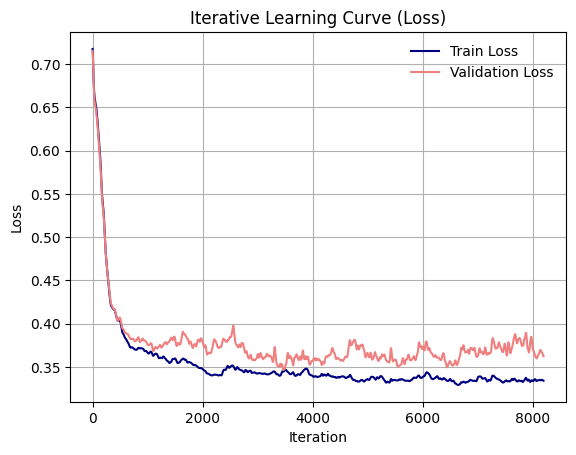

In [134]:
# plot the iterative learning curve (loss)
plt.plot(train_loss_smooth, label='Train Loss', color='navy')
plt.plot(valid_loss_smooth, label='Validation Loss', color='lightcoral')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iterative Learning Curve (Loss)")
plt.grid(visible=True)
plt.legend(frameon=False)

In [27]:
train_acc_smooth = gaussian_filter1d(sa_net.history[:, 'train_acc'], sigma=2)
valid_acc_smooth = gaussian_filter1d(sa_net.history[:, 'valid_acc'], sigma=2)

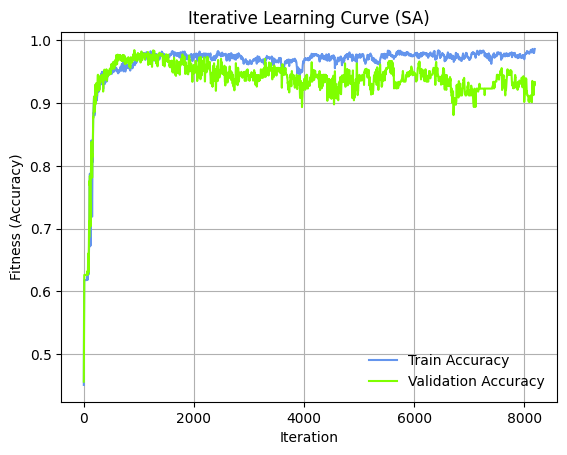

In [28]:
# plot the iterative learning curve (Accuracy)
plt.plot(train_acc_smooth, label='Train Accuracy', color='cornflowerblue')
plt.plot(valid_acc_smooth, label='Validation Accuracy', color='chartreuse')
plt.xlabel("Iteration")
plt.ylabel("Fitness (Accuracy)")
plt.title("Iterative Learning Curve (SA)")
plt.grid(visible=True)
plt.legend(frameon=False)

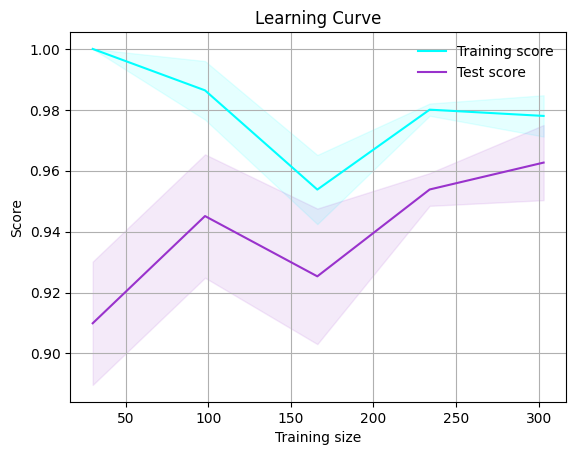

In [136]:
from sklearn.model_selection import learning_curve

# Plot the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    sa_net, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 5), cv=3
)

train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='cyan')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='darkorchid')
plt.plot(train_sizes, train_scores_mean, label="Training score", color='cyan')
plt.plot(train_sizes, test_scores_mean, label="Test score", color='darkorchid')
plt.title("Learning Curve")
plt.xlabel("Training size")
plt.ylabel("Score")
plt.grid(visible=True)
plt.legend(frameon=False)

## GA

In [29]:
from pyperch.neural.ga_nn import GAModule  

In [34]:
ga_net = NeuralNetClassifier(
    module=GAModule,
    max_epochs=1024,
    verbose=0,
    callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True),],
    # use nn.CrossEntropyLoss instead of default nn.NLLLoss
    # for use with raw prediction values instead of log probabilities
    criterion=nn.CrossEntropyLoss(),
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

In [30]:
GAModule.register_ga_training_step()

In [94]:
from sklearn.model_selection import GridSearchCV

# deactivate skorch-internal train-valid split and verbose logging
ga_net.set_params(train_split=False, verbose=0, )

# module specific parameters need to begin with 'module__'
default_params = {
    'module__input_dim': [30],
    'module__output_dim': [2],
    'module__hidden_layers': [1],
    'module__hidden_units': [32],
    'module__activation': [nn.Sigmoid()],
}

grid_search_params = {
    'module__population_size': [100, 200, 300],
    'module__to_mutate': [30, 60, 120],
    'module__to_mate': [50, 150],
    **default_params,
}

gs = GridSearchCV(ga_net, grid_search_params, refit=False, cv=3, scoring='accuracy', verbose=2)

gs.fit(X_train, y_train)
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END module__activation=Sigmoid(), module__hidden_layers=1, module__hidden_units=32, module__input_dim=30, module__output_dim=2, module__population_size=100, module__to_mate=50, module__to_mutate=30; total time= 5.9min
[CV] END module__activation=Sigmoid(), module__hidden_layers=1, module__hidden_units=32, module__input_dim=30, module__output_dim=2, module__population_size=100, module__to_mate=50, module__to_mutate=30; total time= 6.4min
[CV] END module__activation=Sigmoid(), module__hidden_layers=1, module__hidden_units=32, module__input_dim=30, module__output_dim=2, module__population_size=100, module__to_mate=50, module__to_mutate=30; total time= 7.5min
[CV] END module__activation=Sigmoid(), module__hidden_layers=1, module__hidden_units=32, module__input_dim=30, module__output_dim=2, module__population_size=100, module__to_mate=50, module__to_mutate=60; total time=10.2min
[CV] END module__activation=Sigmoid(), module__

[CV] END module__activation=Sigmoid(), module__hidden_layers=1, module__hidden_units=32, module__input_dim=30, module__output_dim=2, module__population_size=300, module__to_mate=50, module__to_mutate=30; total time=   0.3s


KeyboardInterrupt



In [49]:
ga_net = NeuralNetClassifier(
    module=GAModule,
    module__input_dim=30,
    module__output_dim=2,
    module__hidden_units=32,
    module__hidden_layers=1,
    module__activation=nn.Sigmoid(),
    module__population_size=100,
    module__to_mutate=30,
    module__to_mate=50,
    max_epochs=4096,
    verbose=0,
    callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True),],
    # use nn.CrossEntropyLoss instead of default nn.NLLLoss
    # for use with raw prediction values instead of log probabilities
    criterion=nn.CrossEntropyLoss(),
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

In [50]:
ga_net.fit(X_train, y_train)

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=GAModule(
    (dropout): Dropout(p=0, inplace=False)
    (activation): Sigmoid()
    (output_activation): Softmax(dim=-1)
    (layers): ModuleList(
      (0): Linear(in_features=30, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=32, bias=True)
      (2): Linear(in_features=32, out_features=2, bias=True)
    )
  ),
)

In [51]:
print(classification_report(y_test, ga_net.predict(X_test)))

print(confusion_matrix(y_test, ga_net.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.87      0.91        39
           1       0.94      0.97      0.95        75

    accuracy                           0.94       114
   macro avg       0.94      0.92      0.93       114
weighted avg       0.94      0.94      0.94       114

[[34  5]
 [ 2 73]]


In [46]:
train_loss_smooth = gaussian_filter1d(ga_net.history[:, 'train_loss'], sigma=2)
valid_loss_smooth = gaussian_filter1d(ga_net.history[:, 'valid_loss'], sigma=2)

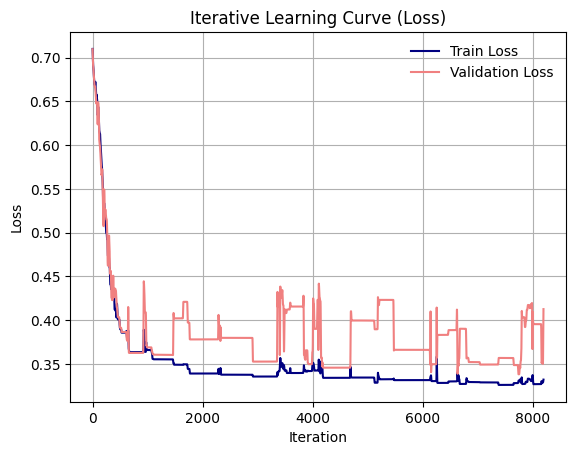

In [47]:
# plot the iterative learning curve (loss)
plt.plot(train_loss_smooth, label='Train Loss', color='navy')
plt.plot(valid_loss_smooth, label='Validation Loss', color='lightcoral')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iterative Learning Curve (Loss)")
plt.grid(visible=True)
plt.legend(frameon=False)

In [52]:
train_acc_smooth = gaussian_filter1d(ga_net.history[:, 'train_acc'], sigma=1)
valid_acc_smooth = gaussian_filter1d(ga_net.history[:, 'valid_acc'], sigma=1)

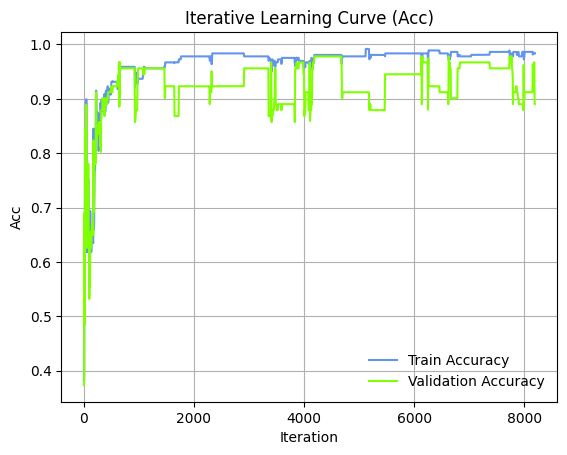

In [53]:
# plot the iterative learning curve (f1uracy)
plt.plot(train_acc_smooth, label='Train Accuracy', color='cornflowerblue')
plt.plot(valid_acc_smooth, label='Validation Accuracy', color='chartreuse')
plt.xlabel("Iteration")
plt.ylabel("Acc")
plt.title("Iterative Learning Curve (Acc)")
plt.grid(visible=True)
plt.legend(frameon=False)

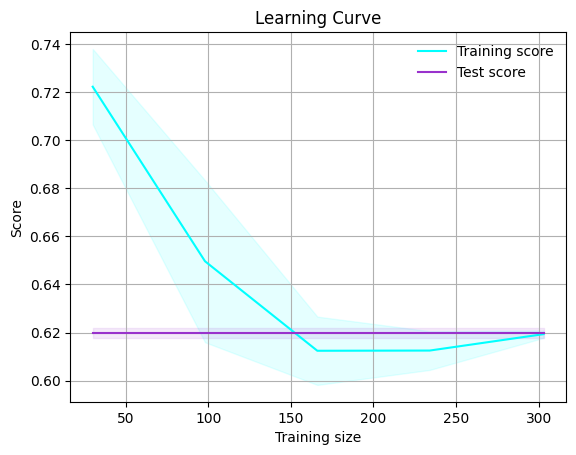

In [16]:
from sklearn.model_selection import learning_curve

# Plot the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    ga_net, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 5), cv=3
)

train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='cyan')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='darkorchid')
plt.plot(train_sizes, train_scores_mean, label="Training score", color='cyan')
plt.plot(train_sizes, test_scores_mean, label="Test score", color='darkorchid')
plt.title("Learning Curve")
plt.xlabel("Training size")
plt.ylabel("Score")
plt.grid(visible=True)
plt.legend(frameon=False)